In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from dataclasses import dataclass, field
from typing import List, Tuple

%matplotlib ipympl

In [3]:
x, y, h = 10, 20, 30

space = np.array([
    [1, 2, 3, 1],
    [1, 2, 3, 1],
])

In [62]:
@dataclass
class Camera:
    focal_length: float
    resolution: Tuple[int, int]
    sensor_size: Tuple[int, int]

    position: np.ndarray#=field(default_factory=np.array([0., 0., 0.]))
    angle: np.ndarray#=field(default_factory=np.array([0., 1., 0.]))  # angle in degrees

    def __post_init__(self):
        beta, alpha, gamma = self.angle  # R_x, R_y, R_z | pitch, yaw, roll

        sin_beta, cos_beta = np.sin(np.deg2rad(beta)), np.cos(np.deg2rad(beta))
        sin_alpha, cos_alpha = np.sin(np.deg2rad(alpha)), np.cos(np.deg2rad(alpha))
        sin_gamma, cos_gamma = np.sin(np.deg2rad(gamma)), np.cos(np.deg2rad(gamma))

        self.rotation = np.array([
            [cos_alpha*cos_beta, cos_alpha*sin_beta*sin_gamma - sin_alpha*cos_gamma, cos_alpha*sin_beta*cos_gamma + sin_alpha*sin_gamma],
            [sin_alpha*cos_beta, sin_alpha*sin_beta*sin_gamma + cos_alpha*cos_gamma, sin_alpha*sin_beta*cos_gamma - cos_alpha*sin_gamma],
            [-sin_beta, cos_beta*sin_gamma, cos_beta*cos_gamma]
        ])
        unit_vec = np.array([0, 0, 1])
        # v = np.matmul(self.rotation, unit_vec.T)
        v = unit_vec @ self.rotation
        self.unit_angle = v / np.linalg.norm(v)

        self.intrinsic = np.array([
            [self.focal_length/self.sensor_size[0], 0, self.resolution[0]/2],
            [0, self.focal_length/self.sensor_size[1], self.resolution[1]/2],
            [0, 0, 1]
        ])

        print('intrinsic')
        print(self.intrinsic)
        
    '''
        Transform world coordinate to pixel coordinate
            - World to camera coordinate
            - Camera to pixel coordinate
    '''
    def transform(self, 
        space,
        world_position
    ):
        # convention assumption on viewing angles
        translation = np.array(self.position - world_position)  # row vector
        m = np.zeros((4, 4))
        m[0:3, 0:3] = self.rotation
        m[0:3, -1] = translation
        m[-1, -1] = 1

        # image_space = np.matmul(space, m)
        image_space = np.matmul(m, space.T).T
        camera_space = np.matmul(self.intrinsic, image_space.T).T
        pixel_space = np.matmul(self.abc, camera_space.T).T

        return pixel_space

    def pixel2ray(self, pixel):
        translation = np.array(self.position) 
        camera_coor = pixel @ np.linalg.inv(self.intrinsic.T)
        # camera_coor = pixel @ np.linalg.inv(self.intrinsic).T
        world_coor = (camera_coor @ self.rotation) + translation

        vector = world_coor - self.position
        directional_vector = vector / np.linalg.norm(vector)

        return directional_vector

# camera = Camera(16.16003, (512, 512), np.array([8, 2.5, 3]), (17.288, 232.093, 0))
camera = Camera(20., (512, 512), (25, 20), np.array([1, 1, 2]), (0, 0, 0))
pixel = np.array([250, 250, 1])
ray = camera.pixel2ray(pixel)
print(ray, camera.unit_angle, 1.5*ray)

intrinsic
[[  0.8   0.  256. ]
 [  0.    1.  256. ]
 [  0.    0.    1. ]]
[-0.77667056 -0.62133645  0.10355607] [0. 0. 1.] [-1.16500584 -0.93200467  0.15533411]


In [63]:

pixels = np.array([
    [0, 0, 1],
    [0, 512, 1],
    [512, 0, 1],
    [512, 512, 1],
])
rays = camera.pixel2ray(pixels)

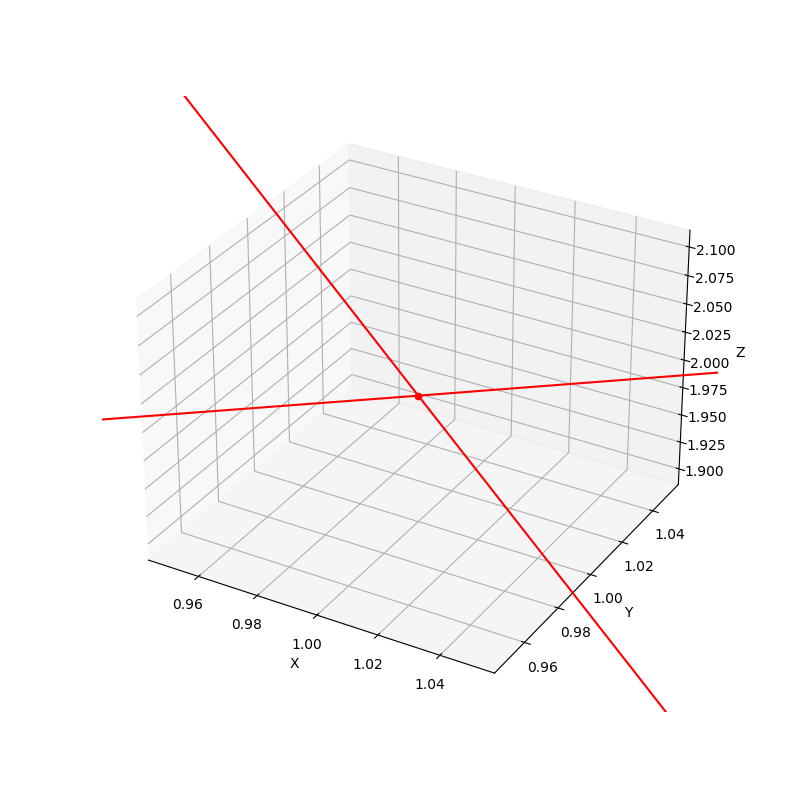

In [64]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

ax.scatter(*camera.position, color='red')

stack_origin = np.stack([camera.position]*4)
pixels = np.array([
    [0, 0, 1],
    [0, 512, 1],
    [512, 0, 1],
    [512, 512, 1],
])
rays = camera.pixel2ray(pixels)

ax.quiver(
    stack_origin[:, 0],
    stack_origin[:, 1],
    stack_origin[:, 2],
    rays[:, 0],
    rays[:, 1],
    rays[:, 2],
    color='red', length=1.0, arrow_length_ratio=.1, normalize=True
)

# ax.quiver(*camera.position, *v, color='red')

# plt.axis('off')
plt.show()

In [25]:
beta, alpha, gamma = [30, 0, 0]  # R_x, R_y, R_z | pitch, yaw, roll

sin_beta, cos_beta = np.sin(np.deg2rad(beta)), np.cos(np.deg2rad(beta))
sin_alpha, cos_alpha = np.sin(np.deg2rad(alpha)), np.cos(np.deg2rad(alpha))
sin_gamma, cos_gamma = np.sin(np.deg2rad(gamma)), np.cos(np.deg2rad(gamma))

np.array([
    [cos_alpha*cos_beta, cos_alpha*sin_beta*sin_gamma - sin_alpha*cos_gamma, cos_alpha*sin_beta*cos_gamma + sin_alpha*sin_gamma],
    [sin_alpha*cos_beta, sin_alpha*sin_beta*sin_gamma + cos_alpha*cos_gamma, sin_alpha*sin_beta*cos_gamma - cos_alpha*sin_gamma],
    [-sin_beta, cos_beta*sin_gamma, cos_beta*cos_gamma]
])

array([[ 0.8660254,  0.       ,  0.5      ],
       [ 0.       ,  1.       ,  0.       ],
       [-0.5      ,  0.       ,  0.8660254]])

In [57]:
np.stack([camera.position]*4)[:, 0]

array([1, 1, 1, 1])